In [1]:
import numpy as  np
import subprocess as sp
import scipy
from matplotlib import pyplot as plt

In [2]:
fid_path = "specfem2d/DATA/SOURCE"

with open(fid_path, "r") as fid:
    lines = fid.readlines()

print(lines)

['## Source 1\n', 'source_surf                     = .false.        # source inside the medium, or source automatically moved exactly at the surface by the solver\n', 'xs = 99.19935341285532\n', 'zs = 2477.458540720062\n', '## Source type parameters:\n', '#  1 = elastic force or acoustic pressure\n', '#  2 = moment tensor\n', '# or Initial field type (when initialfield set in Par_file):\n', '# For a plane wave including converted and reflected waves at the free surface:\n', '#  1 = P wave,\n', '#  2 = S wave,\n', '#  3 = Rayleigh wave\n', '# For a plane wave without converted nor reflected waves at the free surface, i.e. with the incident wave only:\n', '#  4 = P wave,\n', '#  5 = S wave\n', '# For initial mode displacement:\n', '#  6 = mode (2,3) of a rectangular membrane\n', 'source_type                     = 1\n', '# Source time function:\n', '# In the case of a source located in an acoustic medium,\n', '# to get pressure for a Ricker in the seismograms, here we need to select a Gau

2468.7700195


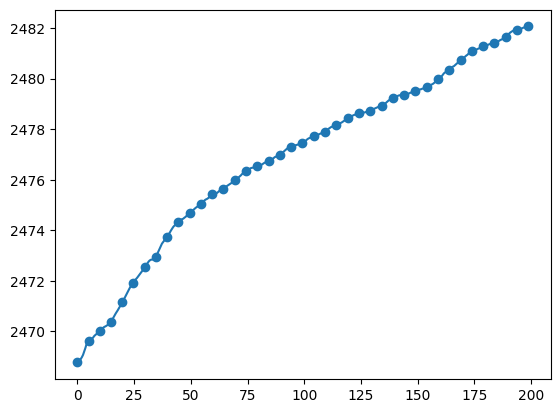

In [3]:
# sources are every 5 m along the line starting at 0

topo = np.loadtxt("Field-Data/topo.txt")

# compute the path length of the topography

L = np.zeros(len(topo))

for i in range(1, len(L)):
    L[i] = L[i-1] + np.sqrt((topo[i,0] - topo[i-1,0])**2 + (topo[i,1] - topo[i-1,1])**2)

stretch = 200.0001/np.max(L)
L *= stretch

# interpolate the x-cordinate as a function of path length
x_interp = scipy.interpolate.interp1d(L, topo[:,0])

# interpolate the elevation as function of the x-cordinate
topo_interp = scipy.interpolate.interp1d(topo[:,0], topo[:,1])

source_x = x_interp(np.arange(0, 205, 5))
source_z = topo_interp(source_x)

plt.plot(topo[:,0], topo[:,1])
plt.scatter(source_x, source_z)

print(source_z[0])

In [4]:
def setpar(path: str, par: str, new_par: str) -> None:
        """
        Reads a parameter file and updates it with a new par value.
        inputs:
            path: The path the parameter file
            par: The parameter to be updated
            new_par: the value for the parameter 
        """

        with open(path, 'r') as fid: 
            lines: list[str] = fid.readlines()

            for i in range(len(lines)):
                s0: str = lines[i].split('=')[0]

                if par in s0 and '#' not in s0:
                    lines[i]  = par + " = " + new_par + '\n'

        with open(path, 'w') as fid:
            fid.writelines(lines)

In [5]:
# make all the source files that you need by copying the original source file
# then change the source location in the new file

src_path = "specfem2d/DATA/SOURCE"

pars = ["xs", "zs", "time_function_type", "name_of_source_file"]

for i in range(len(source_x)):

    des_path = "specfem2d/DATA/" + "SOURCE_{:06d}".format(i)
    
    sp.run(["cp", src_path, des_path])

    for par in pars:
        if par == "xs":
            new_par = str(source_x[i])
        elif par == "zs":
            new_par = str(source_z[i])
        elif par == "time_function_type":
            new_par = "8"
        elif par == "name_of_source_file":
            new_par = "DATA/stf_{:06d}.txt".format(i)

        setpar(des_path, par, new_par)



(0.0, 80.0)

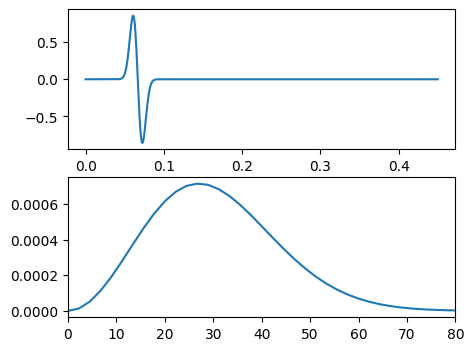

In [2]:
# create STFs

import scipy.signal


dt = 0.000045
Nt = 10000

T = np.arange(0, Nt*dt, dt)

# gaussian stf
stf = lambda t, t0, f0: -8 * (t-t0) * f0 * (np.exp(-1 * ((4*f0)**2) * ((t-t0)**2))) 
f0 = 30.0
t0 = 0.05  + 0.5/f0
S = stf(T, t0, f0)

# ormsby stf
# stf = lambda t, t0, f0, f1, f2, f3: \
#     ((f0**2)/(f1-f0))*(np.sinc(f0*(t-t0))**2) - \
#     ((f1**2)/(f1-f0))*(np.sinc(f1*(t-t0))**2) - \
#     ((f2**2)/(f3-f2))*(np.sinc(f2*(t-t0))**2) + \
#     ((f3**2)/(f3-f2))*(np.sinc(f3*(t-t0))**2)
# f0 = 0
# f1 = 0.1
# f2 = 60
# f3 = 80
# t0 = 0.05
# S = stf(T, t0, f0, f1, f2, f3)

freq, P = scipy.signal.periodogram(S, 1/dt)

fig, ax = plt.subplots(2, 1, figsize=(5,4))
ax[0].plot(T, S)
# ax[0].vlines(0.05, 0, 150)
ax[1].plot(freq, P)
ax[1].set_xlim(0, 80)



In [3]:
# write STF files

Ns = 41

base_path = "d2gauss_stfs_30Hz/"
# base_path = "ormsby_stfs/"

for i in range(Ns):

    fid_name = base_path + "stf_{:06d}.txt".format(i)

    np.savetxt(fid_name, np.vstack((T, S)).T, delimiter=",  ")